In [1]:
import subprocess
command = (
    'nvidia-smi --query-gpu=timestamp,name,memory.free,memory.used,power.draw '
    '--format=csv -l 1 > gpu_log.csv'
)
process = subprocess.Popen(command, shell=True)

/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/server/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.2.2+cu121)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2024-04-12 17:03:16.477127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

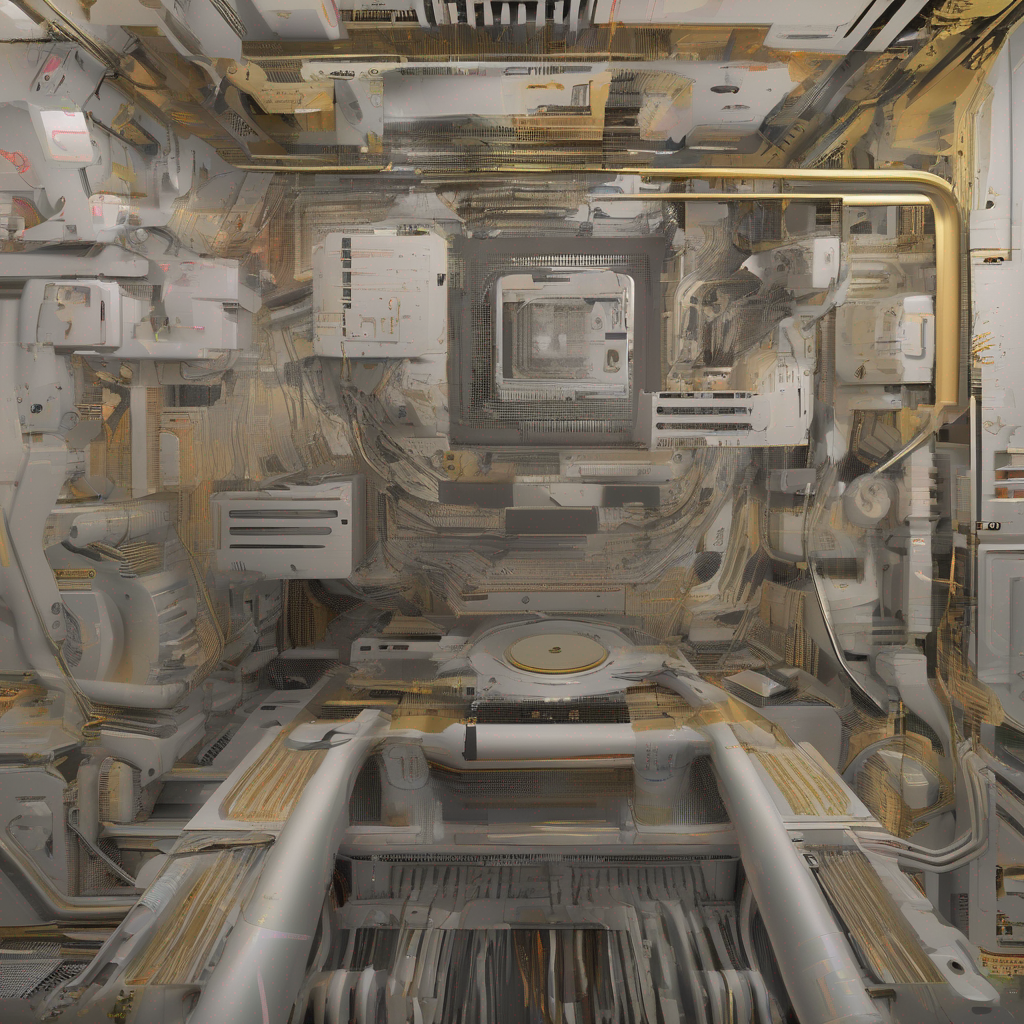

In [2]:
from diffusers import DiffusionPipeline
import torch
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")
prompt = "Compression artifacts"
images = pipe(prompt=prompt).images[0]
images

In [3]:
process.terminate()
import pandas as pd
import numpy as np
data = pd.read_csv('gpu_log.csv')
t = pd.to_datetime(data['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
δt = (np.diff(t)/1e9).astype("float")
P = np.array(data[' power.draw [W]'][:-1].str.replace(' W', '')).astype(float)
E = np.sum(δt*P)
print(E, "Joules")

4952.75 Joules


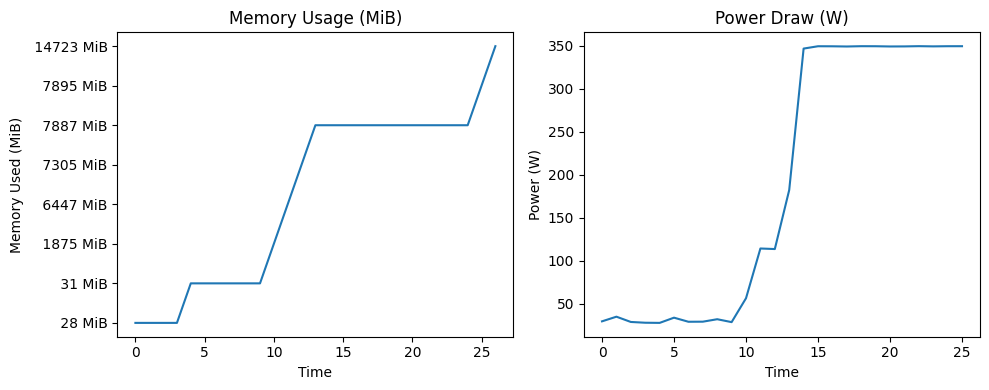

In [4]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Adjust size as needed
ax1.plot(data[' memory.used [MiB]'])
ax1.set_title('Memory Usage (MiB)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Memory Used (MiB)')
ax2.plot(P)
ax2.set_title('Power Draw (W)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Power (W)')
plt.tight_layout()
plt.show()